# Objekte nach Lakshmanan et al. (2009)

Lakshmanan et al. (2009) schlagen einen erweiterten Wasserscheidenalgorithmus vor, um sinnvolle Objekte in Satellitendaten zu definieren, der Hartwigs Vorschlag ähnlich ist, aber darüber hinaus geht.

Im Artikel wird eine Reihe von Termini benutzt:

* Wasserscheidentransformation (<i>watershed transform</i>): eine effizienter Ansatz um Bereiche mit hoher Intensität zu finden, in dem alle möglichen Schwellwerte in einem Durchlauf durch das Bild bestimmt werden. 
* Becken (<i>basin</i>): ein Bereich, der durch den Wasserscheidenalgorithmus indetifiziert wird, indem von einem lokalen Maximum ausgegangen wird.
* Auffälligkeit (<i>saliency</i>): Kriterium, das genutzt wird um zu prüfen, ob ein Bereich erhalten bleiben soll. Im Allgemeinen wird die Auffälligkeit anhand der Beckentiefe definiert, aber in dem Artikel, wird sie dagingegend abgewandelt, dass die Fläche der Becken geprüft wird.
* Hysterese (<i>hysteresis</i>): ein zweiter, verschobener Schwellwert, der für gewöhnlich als Verringerung des ersten definiert wird. Im Artikel wird der Hystereseschwellwert als derjenige definiert, an dem ein Becken herausragend wird.
* Ausläufer (<i>foothill</i>): die Ausläufer kennzeichnen die Unterstützungsregion für das Maximum. Innerhalb dieser Unterstützungsregion können keine neuen Maxima gefunden werden.

In [64]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import ndimage as ndi
import datetime as dt
import load_satellite_data as lsd
from plotting_tools.colormaps import enhanced_colormap
emap = enhanced_colormap()
from skimage.morphology import extrema
import fixed_colourbar as fc
from skimage.morphology import watershed

## 1. Beispiel laden

Zuerst laden wir uns einen Beispielasschnitt.

In [2]:
date = dt.datetime(2012,6,18,12,0)
ir108 = lsd.load_satellite_data(date,"IR_108")

Region suggests use of hdf file


/vols/satellite/home/lenk/anaconda3/envs/tracking/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


## 2. Glättung
Zuerst wird das Bild mit einem Gauß'schen Filter geglättet, um eventuelles Rauschen zu entfernen.

In [3]:
ir108_smoothed = ndi.gaussian_filter(ir108,(1,0.5))

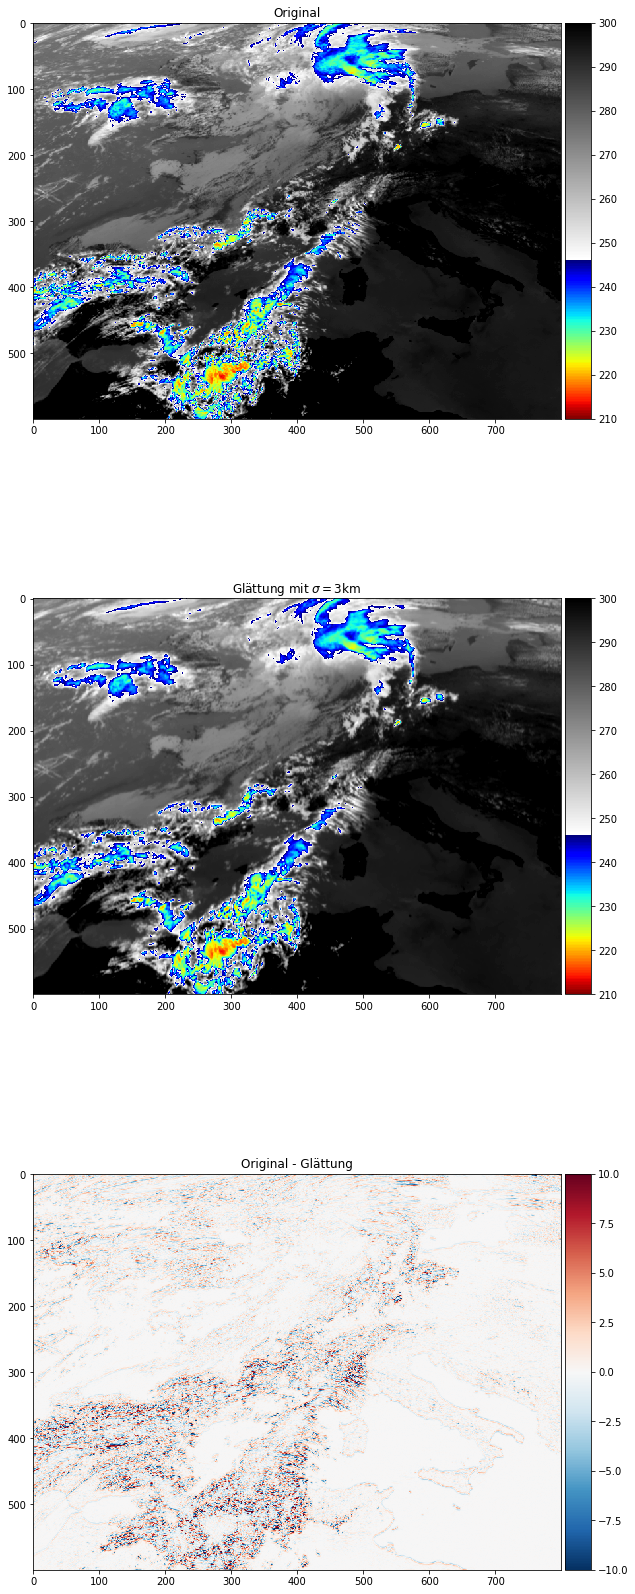

In [12]:
fig,ax = plt.subplots(3,1,figsize=(10,30),sharey=True)
p0 = ax[0].imshow(ir108,vmin=210,vmax=300,cmap=emap)
ax[0].set_title("Original")
fc.colourbar(p0)
p1 = ax[1].imshow(ir108_smoothed,vmin=210,vmax=300,cmap=emap)
ax[1].set_title(r"Glättung mit $\sigma=3\mathrm{km}$")
fc.colourbar(p1)
p2 = ax[2].imshow(ir108-ir108_smoothed,vmin=-10,vmax=10,cmap='RdBu_r')
ax[2].set_title(r"Original - Glättung")
fc.colourbar(p2)

Als nächstes wird das geglättete Bild quantisiert.

## 3. Quantisierung

Für die folgende Analyse wird das Bild in diskrete Schritte quantisiert, um im Originalartikel die Datenstruktur zu begrenzen. Das ist hier wahrscheinlich nicht unbedingt nötig, aber vielleicht hilft es. Die Formel sieht folgendermaßen aus:

$$\begin{equation}
Q_{x,y} = 
\begin{cases}
0 \forall I_{x,y}\leq a \\
\mathrm{round}\left( \frac{I_[x,y} -a }{\delta}right) \\
\end{cases}
\end{equation}$$
und zudem die Minima in Maxima umgewandelt:



In [14]:
def quantise(image,a,b,delta):
    image_dummy = np.zeros_like(image,dtype=np.int)
    
    if a < b:
        min_value = a
        max_value = b
        mode='max'
    else:
        min_value = b
        max_value = a
        mode='min'
        
        if delta > 0:
            delta = -delta
    below_min = np.where(image <= min_value)
    above_max = np.where(image > max_value)
    inside_range = np.where(np.logical_and(image > min_value, image <= max_value))
    
    if mode=='max':
        values = np.rint((image-min_value)/delta)
    
        image_dummy[below_min] = 0
        image_dummy[above_max] = int(np.rint((max_value-min_value) / delta))
        image_dummy[inside_range] = values[inside_range]
    else:
        values = np.rint((image-max_value)/delta)
        
        image_dummy[above_max] = 0
        image_dummy[below_min] = int(np.rint((min_value-max_value) / delta))
        image_dummy[inside_range] = values[inside_range]
    
    return image_dummy

In [35]:
(300-210) / 1

90.0

In [76]:
test = quantise(ir108_smoothed,300,180,-1)

Text(0.5, 1.0, 'Quantisiertes geglättetes Bild')

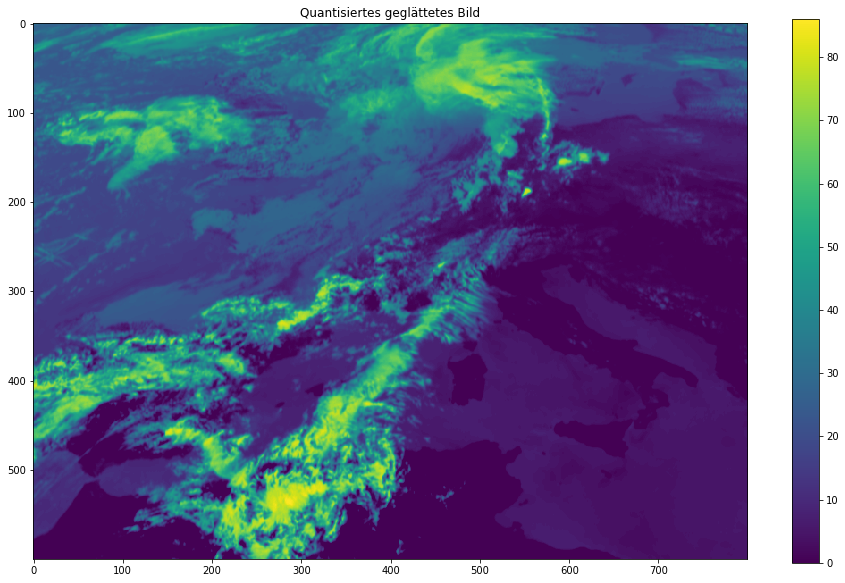

In [77]:
fig,ax = plt.subplots(1,1,figsize=(16,10))
p =ax.imshow(test)
plt.colorbar(p)
ax.set_title("Quantisiertes geglättetes Bild")

In [84]:
maxima = extrema.h_maxima(test,10)

In [85]:
mx_labels,nmx= ndi.label(maxima)

In [86]:
mx_obj = ndi.find_objects(mx_labels,nmx)

In [87]:
centroids = ndi.center_of_mass(test,mx_labels,np.arange(1,nmx))

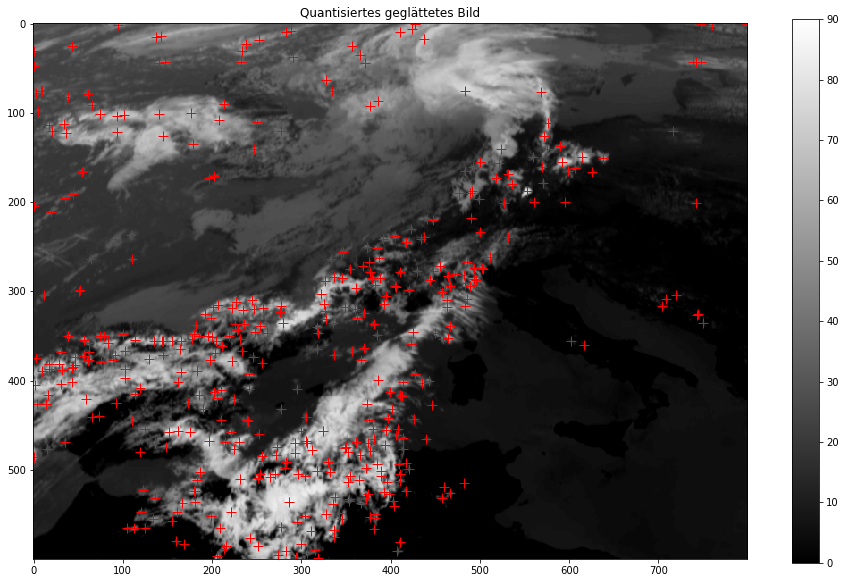

In [88]:
fig,ax = plt.subplots(1,1,figsize=(16,10))
p =ax.imshow(test,vmin=0,vmax=90,cmap='gray')
plt.colorbar(p)
ax.set_title("Quantisiertes geglättetes Bild")

for c in centroids:
    ax.plot(c[1],c[0],'r+',mew=1,markersize=10)

Soweit, so gut. Als nächstes werden die Becken zu den Schwerpunkten gesucht. Um den iterativen Ansatz im Paper zu umgehen, müssen wir die Maskenbildung für die Wasserscheidentransformation anpassen. Im Paper gibt es zwei Kriterien:

1. Die Beckenbildung wird für verschiedene Wasserstände durchgeführt, bis ein Becken eine bestimmte Größe erreicht hat.

2. Um ein solches Becken wird ein Ausläufer definiert, in dem keine neue Beckenbildung stattfinden kann. Dieser Ausläufer wird zum nächsten Schwerpunkt mit einem geodätischen Absatand zugeordnet.

In [103]:
maske = np.ma.masked_greater(test,30).mask*1

In [104]:
distance = ndi.distance_transform_edt(maske)
markers = mx_labels

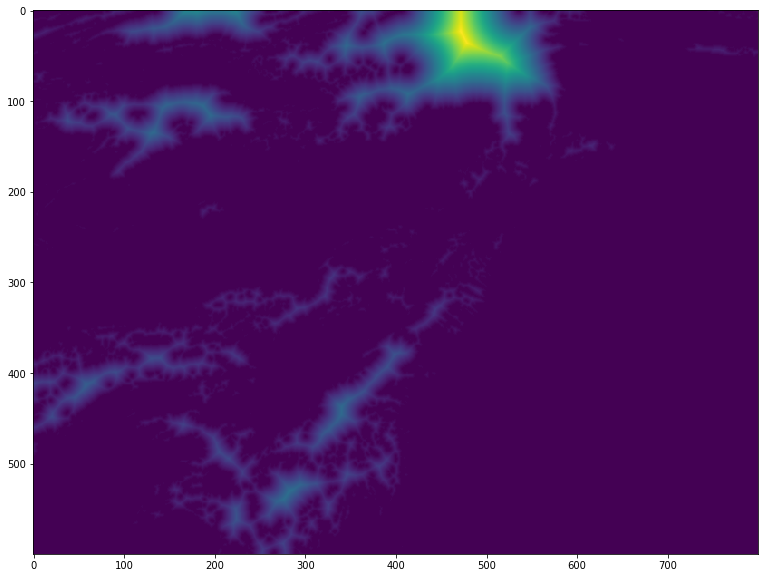

In [105]:
fig,ax = plt.subplots(1,1,figsize=(16,10))
ax.imshow(distance)

In [106]:
labels = watershed(-distance, markers, mask=maske)

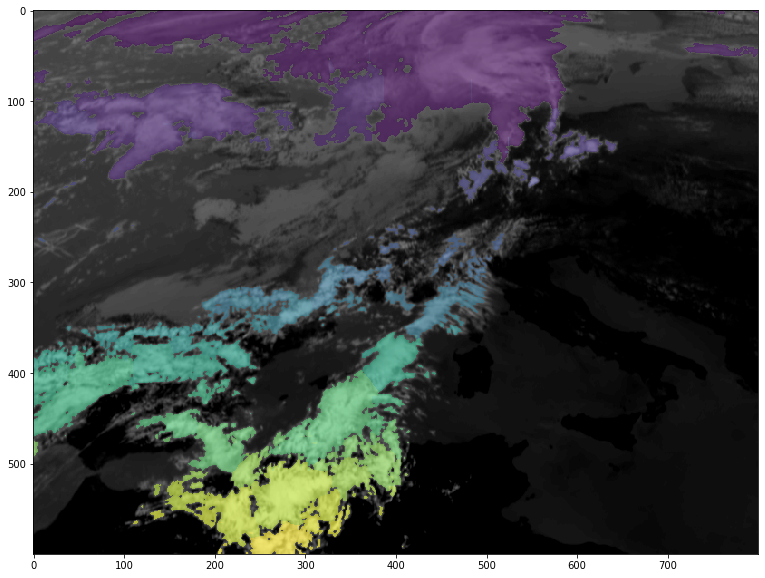

In [107]:
fig,ax = plt.subplots(1,1,figsize=(16,10))
ax.imshow(test,cmap='gray')
plt.imshow(np.ma.masked_less(labels,1),alpha=0.6)